# Deal or No Deal

## Technical Analysis Based LSTM Pricing Model

### Dependency

In [1]:
import os
import glob
import random
from pathlib import Path
from datetime import datetime
from enum import Enum

import matplotlib
%matplotlib inline

import collections
import numpy as np
import pandas as pd

from torch import nn
import torch.tensor
import torch.optim as optim
import torch.nn.functional as F

from talib import RSI, BBANDS, ADOSC

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.mode.chained_assignment = None

### Configs

In [2]:
DATE_BEGIN = datetime.strptime('1998-01-01', '%Y-%m-%d')

TRAINING_DATE_TO = datetime.strptime('2019-06-30', '%Y-%m-%d')

VALIDATION_DATE_FROM = datetime.strptime('2019-07-01', '%Y-%m-%d')
VALIDATION_DATE_TO = datetime.strptime('2019-12-31', '%Y-%m-%d')

TESTING_DATE_FROM = datetime.strptime('2020-01-01', '%Y-%m-%d')
TESTING_DATE_TO = datetime.strptime('2020-02-13', '%Y-%m-%d')

In [3]:
DATA_DIR = '..'
REGION = 'us'
INSTRUMENT = 'unh'

RAW_DATA_FULL_FEATURES_SET = ['date', 'open', 'high', 'low', 'close', 'volume', 'openint']
RAW_DATA_REMOVED_FEATURES_SET = ['open', 'high', 'low', 'close']
RAW_DATA_ADDED_FEATURES_SET = ['volume']
RAW_DATA_FEATURES_SET = RAW_DATA_REMOVED_FEATURES_SET + RAW_DATA_ADDED_FEATURES_SET

RAW_DATA_FEATURES_SET = ['open', 'high', 'low', 'close', 'volume']
RAW_TARGET = 'close'

FEATURES_SET = ['open',
                'high',
                'low',
                'close',
                'volume',
#                 'ta_bbands_up',
#                 'ta_bbands_mid',
#                 'ta_bbands_low',
#                 'ta_osc_ad'
               ]
TARGET = 'close_delta'

EXECLUDE_FIELDS = ['date', 'openint', 'close_t1']

## Helpers

### Market Data

In [4]:
def fetch_instrument_file(instrument, region, base_dir):
    cwd = os.getcwd()
    os.chdir(base_dir)
    
    instrument_file_list = result = list(Path('.').rglob(f"*{instrument}*.txt"))
    if not instrument_file_list:
        os.chdir(cwd)
        raise Exception(f'Cannot find file for instrument {instrument}')
    if len(instrument_file_list) > 1:
        os.chdir(cwd)
        raise Exception(f'Found multiple file for instrument {instrument}')
        
    os.chdir(cwd)
    return str(os.path.normpath(
                    os.path.join(os.getcwd(), base_dir, instrument_file_list[0])
                )
            )

instrument_data_file = fetch_instrument_file(INSTRUMENT, REGION, DATA_DIR)
instrument_data_file

'/Users/mina/deal-nodeal/data/daily/us/nyse stocks/2/unh.us.txt'

# Data Preparation 

In [5]:
instrument_data_file = fetch_instrument_file(INSTRUMENT, REGION, DATA_DIR)
instrument_data_file

'/Users/mina/deal-nodeal/data/daily/us/nyse stocks/2/unh.us.txt'

In [6]:
df = pd.read_csv(instrument_data_file)
df.columns = RAW_DATA_FULL_FEATURES_SET

df.date = pd.to_datetime(df.date, format='%Y%m%d')
df['volume'] = df['volume'].astype('float64')
df

,date,open,high,low,close,volume,openint
0,1990-03-26,0.25264,0.25264,0.25264,0.25264,473990.0,0
1,1990-03-27,0.25264,0.26996,0.25264,0.26996,4493732.0,0
2,1990-03-28,0.26996,0.26996,0.26119,0.26119,1793083.0,0
3,1990-03-29,0.26996,0.26996,0.26119,0.26119,617291.0,0
4,1990-03-30,0.26996,0.26996,0.26119,0.26119,2017221.0,0
...,...,...,...,...,...,...,...
7510,2020-01-16,298.00000,300.99000,295.93000,300.74000,3710344.0,0
7511,2020-01-17,300.01000,300.70000,295.88000,298.47000,4632160.0,0
7512,2020-01-21,296.89000,302.54000,296.01000,300.53000,4963132.0,0
7513,2020-01-22,301.99000,302.13000,297.35000,300.59000,3117568.0,0


#### Split/Revers dataset - (Training / Validation / Testing)

In [7]:
training_df = df[(df['date'] >= DATE_BEGIN) & (df['date'] <= TRAINING_DATE_TO)] 
training_df = training_df.reset_index()
training_df.drop(['index'], axis=1, inplace=True)
training_df = training_df[::-1]
training_df

validation_df = df[(df['date'] >= DATE_BEGIN) & (df['date'] <= VALIDATION_DATE_TO)] 
validation_df = validation_df.reset_index()
validation_df.drop(['index'], axis=1, inplace=True)
validation_df = validation_df[::-1]
validation_df

testing_df = df[(df['date'] >= DATE_BEGIN) & (df['date'] <= TESTING_DATE_TO)] 
testing_df = testing_df.reset_index()
testing_df.drop(['index'], axis=1, inplace=True)
testing_df = testing_df[::-1]
testing_df

,date,open,high,low,close,volume,openint
5405,2019-06-28,244.4000,244.6500,236.6200,241.9300,6785360.0,0
5404,2019-06-27,242.1800,246.0400,241.0900,244.2400,3395049.0,0
5403,2019-06-26,245.8900,245.9700,241.0600,241.4000,3885971.0,0
5402,2019-06-25,247.1800,248.9000,245.3200,245.5600,3210315.0,0
5401,2019-06-24,249.1900,250.4800,245.7600,247.5200,3190897.0,0
...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0


,date,open,high,low,close,volume,openint
5533,2019-12-31,293.6600,294.0900,291.1500,293.9800,2224237.0,0
5532,2019-12-30,296.0500,296.5400,293.4500,293.8500,1512088.0,0
5531,2019-12-27,296.0100,296.5400,295.0140,295.9700,1547211.0,0
5530,2019-12-26,295.3000,296.2600,294.5400,295.6500,1050688.0,0
5529,2019-12-24,295.2600,295.8300,293.5600,294.5400,714032.0,0
...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0


,date,open,high,low,close,volume,openint
5548,2020-01-23,300.0100,300.5800,296.6500,299.4600,3169442.0,0
5547,2020-01-22,301.9900,302.1300,297.3500,300.5900,3117568.0,0
5546,2020-01-21,296.8900,302.5400,296.0100,300.5300,4963132.0,0
5545,2020-01-17,300.0100,300.7000,295.8800,298.4700,4632160.0,0
5544,2020-01-16,298.0000,300.9900,295.9300,300.7400,3710344.0,0
...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0


In [8]:
scaler = MinMaxScaler()

class features_extraction_ops(Enum):
    calc_features_X = 'calc_features_X'
    calc_target_y = 'calc_target_y'
    
    clean = 'clean'
    
    statistics = 'statistics'
    
    normalize_train = 'normalize_train'
    normalize_validation = 'normalize_validation'
    normalize_test = 'normalize_test'
    
    profile = 'profile'

def features_extraction(df, ops = []):
    def _calc_feature_X(df):
        target_field_values = df[RAW_TARGET].values
        df['ta_bbands_up'], df['ta_bbands_mid'], df['ta_bbands_low'] = BBANDS(target_field_values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        
        high = df['high'].values
        low = df['low'].values
        close = df['close'].values
        volume = df['volume'].values
        df['ta_osc_ad'] = ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
        return df
    
    def _calc_target_y(df):
        df[f'{RAW_TARGET}_t1'] = df[RAW_TARGET].shift(-1)
        df[f'{RAW_TARGET}_delta'] = df[f'{RAW_TARGET}_t1'] - df[RAW_TARGET]
        return df
    
    def _clean(df):
        df.dropna(inplace=True)
        return df

    def _statistics(df):
        return df.describe()
    
    def _normalize_train(df):
        for feature in df.columns:
            if feature == 'date' or feature == TARGET:
                continue
                LR = LogisticRegression(C=0.01, solver='liblinear').fit(normalized_x_train, y_train)
            df[feature] = scaler.fit_transform(df[[feature]])
        return df
    
    def _normalize_validation(df):
        for feature in df.columns:
            if feature == 'date' or feature == TARGET:
                continue    
            df[feature] = scaler.transform(df[[feature]])        
        return df
    
    def _normalize_test(df):
        for feature in df.columns:
            if feature == 'date' or feature == TARGET:
                continue    
            df[feature] = scaler.transform(df[[feature]])        
        return df
    
    def _profile(df):
        return ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

    if features_extraction_ops.calc_features_X in ops:
        df = _calc_feature_X(df)
    elif features_extraction_ops.calc_target_y in ops:
        df = _calc_target_y(df)
    elif features_extraction_ops.clean in ops:
        df = _clean(df)
    elif features_extraction_ops.statistics in ops:
        df = _statistics(df)
    elif features_extraction_ops.normalize_train in ops:
        df = _normalize_train(df)
    elif features_extraction_ops.normalize_validation in ops:
        df = _normalize_validation(df)
    elif features_extraction_ops.normalize_test in ops:
        df = _normalize_test(df)
    elif features_extraction_ops.profile in ops:
        return _profile(df)
        
    return df


# Data Preparation /Testings


In [9]:
training_df = features_extraction(training_df, [features_extraction_ops.calc_features_X])
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad
5405,2019-06-28,244.4000,244.6500,236.6200,241.9300,6785360.0,0,NaN,NaN,NaN,NaN
5404,2019-06-27,242.1800,246.0400,241.0900,244.2400,3395049.0,0,NaN,NaN,NaN,NaN
5403,2019-06-26,245.8900,245.9700,241.0600,241.4000,3885971.0,0,NaN,NaN,NaN,NaN
5402,2019-06-25,247.1800,248.9000,245.3200,245.5600,3210315.0,0,NaN,NaN,NaN,NaN
5401,2019-06-24,249.1900,250.4800,245.7600,247.5200,3190897.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0,5.748677,5.350765,4.952853,-1.057607e+07
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0,5.715432,5.340745,4.966058,-7.910136e+06
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0,5.666771,5.326815,4.986859,-3.876711e+06
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0,5.618907,5.313335,5.007763,-3.760994e+06


In [10]:
training_df = features_extraction(training_df, [features_extraction_ops.calc_target_y])
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5405,2019-06-28,244.4000,244.6500,236.6200,241.9300,6785360.0,0,NaN,NaN,NaN,NaN,244.2400,2.3100
5404,2019-06-27,242.1800,246.0400,241.0900,244.2400,3395049.0,0,NaN,NaN,NaN,NaN,241.4000,-2.8400
5403,2019-06-26,245.8900,245.9700,241.0600,241.4000,3885971.0,0,NaN,NaN,NaN,NaN,245.5600,4.1600
5402,2019-06-25,247.1800,248.9000,245.3200,245.5600,3210315.0,0,NaN,NaN,NaN,NaN,247.5200,1.9600
5401,2019-06-24,249.1900,250.4800,245.7600,247.5200,3190897.0,0,NaN,NaN,NaN,NaN,250.1400,2.6200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0,5.748677,5.350765,4.952853,-1.057607e+07,5.4694,-0.0171
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0,5.715432,5.340745,4.966058,-7.910136e+06,5.4172,-0.0522
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0,5.666771,5.326815,4.986859,-3.876711e+06,5.3911,-0.0261
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0,5.618907,5.313335,5.007763,-3.760994e+06,5.3995,0.0084


In [11]:
training_df = features_extraction(training_df, [features_extraction_ops.clean])
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5386,2019-06-03,238.3800,240.6600,232.9800,233.5100,5064735.0,0,250.361575,242.961000,235.560425,-3.406141e+05,238.6800,5.1700
5385,2019-05-31,238.8300,240.4900,236.3900,238.6800,3328706.0,0,250.421865,242.798500,235.175135,-5.534790e+05,240.3700,1.6900
5384,2019-05-30,238.8000,242.1900,238.2300,240.3700,2681501.0,0,250.268541,242.605000,234.941459,-5.212981e+05,239.2800,-1.0900
5383,2019-05-29,236.2100,239.9000,234.8400,239.2800,4010018.0,0,250.283962,242.499000,234.714038,5.024977e+05,238.9400,-0.3400
5382,2019-05-28,245.3000,246.0900,238.7800,238.9400,6253217.0,0,249.967150,242.168000,234.368850,-1.026920e+06,244.4400,5.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1998-01-09,5.4865,5.5040,5.3734,5.3734,10305645.0,0,5.777865,5.359930,4.941995,-9.409522e+06,5.4865,0.1131
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0,5.748677,5.350765,4.952853,-1.057607e+07,5.4694,-0.0171
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0,5.715432,5.340745,4.966058,-7.910136e+06,5.4172,-0.0522
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0,5.666771,5.326815,4.986859,-3.876711e+06,5.3911,-0.0261


In [12]:
# df_profiler = features_extraction(df, [features_extraction_ops.profile])
# df_profiler

In [13]:
training_df = features_extraction(training_df, [features_extraction_ops.normalize_train])
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5386,2019-06-03,0.845299,0.848024,0.836133,0.827225,0.027258,0.0,0.860480,0.908680,0.918543,0.605080,0.845811,5.1700
5385,2019-05-31,0.846917,0.847417,0.848542,0.845811,0.017915,0.0,0.860691,0.908063,0.917026,0.601547,0.851886,1.6900
5384,2019-05-30,0.846809,0.853496,0.855238,0.851886,0.014431,0.0,0.860155,0.907328,0.916106,0.602081,0.847968,-1.0900
5383,2019-05-29,0.837494,0.845307,0.842902,0.847968,0.021581,0.0,0.860209,0.906925,0.915211,0.619077,0.846745,-0.3400
5382,2019-05-28,0.870189,0.867442,0.857240,0.846745,0.033654,0.0,0.859102,0.905668,0.913853,0.593687,0.866518,5.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1998-01-09,0.007612,0.007131,0.007860,0.007075,0.055464,0.0,0.005759,0.006153,0.010778,0.454524,0.007482,0.1131
4,1998-01-08,0.007550,0.007256,0.008146,0.007482,0.056610,0.0,0.005657,0.006118,0.010820,0.435158,0.007420,-0.0171
3,1998-01-07,0.007330,0.007068,0.007860,0.007420,0.052898,0.0,0.005541,0.006080,0.010872,0.479416,0.007233,-0.0522
2,1998-01-06,0.007050,0.006882,0.007448,0.007233,0.046881,0.0,0.005370,0.006027,0.010954,0.546376,0.007139,-0.0261


# Data Preparation /Training

In [110]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def _get_ops(op):
    if op == 'avg':
        return np.mean

    raise Exception(f'Unknown operation {op}')


def _aggregate_collection(lst, op):
    if len(lst) == 0:
        return {}
    elif len(lst) == 1:
        return lst[0]
    else:
        aggrgated_values_dict = {}
        for entry in lst:
            for key, value in entry.items():
                if key in aggrgated_values_dict:
                    aggrgated_values_dict[key].append(value)
                else:
                    aggrgated_values_dict[key] = [value]

        final_aggrgated_values_dict = {}
        for key, values in aggrgated_values_dict.items():
            values = [e for e in values if e]
            final_aggrgated_values_dict[key] = op(values)

        return final_aggrgated_values_dict


def _day_aggregator_handler(dataset, **kwargs):
    length = kwargs['length']
    return dataset[0:length], dataset[length:]


def _week_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 5, **kwargs)


def _month_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 21, **kwargs)


def _quarterly_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 21 * 3, **kwargs)


def _yearly_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 21 * 12, **kwargs)


def _universal_aggregator_handler(dataset, period_range, **kwargs):
    length = kwargs['length']
    ops = _get_ops(kwargs['op'])

    if length == -1:
        return [_aggregate_collection(dataset, ops)], []

    else:
        aggregated_dataset = []

        raw_dataset = dataset[0:length]
        raw_chunked_dataset = chunks(raw_dataset, period_range)
        for week in raw_chunked_dataset:
            aggregated_dataset.append(_aggregate_collection(week, ops))

        return aggregated_dataset, dataset[length:]


def features_aggregator(dataset, features_descriptors):
    aggregated_dataset = []
    for feature_set in features_descriptors:
        index, length, handler, params = feature_set['index'], feature_set['length'], feature_set['handler'], feature_set['params']

        if length == -1:
            period_range = len(dataset)
            step_aggregated_dataset, dataset = handler(dataset, period_range, **{
                'index': index,
                'length': length,

                **params
            })
        else:
            step_aggregated_dataset, dataset = handler(dataset, **{
                'index': index,
                'length': length,

                **params
            })

        if len(step_aggregated_dataset) > 0:
            aggregated_dataset += step_aggregated_dataset

        if len(dataset) == 0:
            return aggregated_dataset

    return aggregated_dataset


def dataset_generator(df, shift_range, repeat_out):
    _features_descriptors = [
        {'index': 0, 'length': 21 * 12 * 1, 'handler': _day_aggregator_handler, 'params': {}},
#         {'index': 1, 'length': 21 * 12 * 6, 'handler': _week_aggregator_handler, 'params': {'op': 'avg'}},
#         {'index': 2, 'length': 21 * 12 * 6, 'handler': _month_aggregator_handler, 'params': {'op': 'avg'}},
#         {'index': 3, 'length': 21 * 12 * 6, 'handler': _quarterly_aggregator_handler, 'params': {'op': 'avg'}},
#         {'index': 4, 'length': 21 * 12 * 6, 'handler': _yearly_aggregator_handler, 'params': {'op': 'avg'}},
#         {'index': 5, 'length': -1, 'handler': _universal_aggregator_handler, 'params': {'op': 'avg'}},
    ]

    dup_df = df.copy()
    dup_df.drop(EXECLUDE_FIELDS, axis=1, inplace=True)
    
    dataset = list(dup_df.T.to_dict().values())
    
    generated_dataset = []
    while repeat_out > 0:
        subset = features_aggregator(dataset, _features_descriptors)
        generated_dataset.append(subset)
        
        dataset = dataset[shift_range:]
        repeat_out -= 1

    return generated_dataset

In [111]:
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5386,2019-06-03,0.845299,0.848024,0.836133,0.827225,0.027258,0.0,0.860480,0.908680,0.918543,0.605080,0.845811,5.1700
5385,2019-05-31,0.846917,0.847417,0.848542,0.845811,0.017915,0.0,0.860691,0.908063,0.917026,0.601547,0.851886,1.6900
5384,2019-05-30,0.846809,0.853496,0.855238,0.851886,0.014431,0.0,0.860155,0.907328,0.916106,0.602081,0.847968,-1.0900
5383,2019-05-29,0.837494,0.845307,0.842902,0.847968,0.021581,0.0,0.860209,0.906925,0.915211,0.619077,0.846745,-0.3400
5382,2019-05-28,0.870189,0.867442,0.857240,0.846745,0.033654,0.0,0.859102,0.905668,0.913853,0.593687,0.866518,5.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1998-01-09,0.007612,0.007131,0.007860,0.007075,0.055464,0.0,0.005759,0.006153,0.010778,0.454524,0.007482,0.1131
4,1998-01-08,0.007550,0.007256,0.008146,0.007482,0.056610,0.0,0.005657,0.006118,0.010820,0.435158,0.007420,-0.0171
3,1998-01-07,0.007330,0.007068,0.007860,0.007420,0.052898,0.0,0.005541,0.006080,0.010872,0.479416,0.007233,-0.0522
2,1998-01-06,0.007050,0.006882,0.007448,0.007233,0.046881,0.0,0.005370,0.006027,0.010954,0.546376,0.007139,-0.0261


In [113]:
train_dataset = dataset_generator(training_df, shift_range=1, repeat_out=1000)
print('Total seqs: ', len(train_dataset))
print('1s seq length: ', len(train_dataset[0]))
print('1s seq: ')
train_dataset[0][0]

Total seqs:  1000
1s seq length:  252
1s seq: 


{'open': 0.845298732427954,
 'high': 0.848024424799267,
 'low': 0.836133224452722,
 'close': 0.8272246622234958,
 'volume': 0.027257688842416895,
 'ta_bbands_up': 0.8604804660634003,
 'ta_bbands_mid': 0.9086802861720751,
 'ta_bbands_low': 0.9185428048496936,
 'ta_osc_ad': 0.6050804454999144,
 'close_delta': 5.170000000000016}

In [114]:
def pad_dataset_sequence(dataset):
    if len(dataset) == 0:
        return dataset

    max_sequence = max([len(e) for e in dataset])

    input_example_dict = dataset[0][0]
    pad_example_dict = {k: 0.0 for k, _ in input_example_dict.items()}

    for example in dataset:
        residual_sequence_length = max_sequence - len(example)
        if residual_sequence_length > 0:
            for e in [pad_example_dict] * residual_sequence_length:
                example.append(e)

    return dataset

print('Sequences length freq table (before padding)', collections.Counter([len(e) for e in train_dataset]), sep='\n')
train_dataset = pad_dataset_sequence(train_dataset)
print('Sequences length freq table (after padding)', collections.Counter([len(e) for e in train_dataset]), sep='\n')

Sequences length freq table (before padding)
Counter({252: 1000})
Sequences length freq table (after padding)
Counter({252: 1000})


# Data Preparation /Validation

In [115]:
validation_subset_df = df[(df['date'] >= VALIDATION_DATE_FROM) & (df['date'] <= VALIDATION_DATE_TO)]
validation_dataset_size = len(validation_subset_df.index)
print('Validation dataset size: ', validation_dataset_size)

Validation dataset size:  128


In [116]:
validation_df = features_extraction(validation_df, [features_extraction_ops.calc_features_X])
validation_df = features_extraction(validation_df, [features_extraction_ops.calc_target_y])
validation_df = features_extraction(validation_df, [features_extraction_ops.clean])
validation_df = features_extraction(validation_df, [features_extraction_ops.normalize_validation])
validation_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5438,2019-08-15,-0.012286,-0.012286,-0.012286,-0.012286,-0.012285,-0.012286,-0.012286,-0.012286,-0.012286,-0.012193,-0.012286,-1.737102e-10
5437,2019-08-14,-0.012286,-0.012286,-0.012286,-0.012286,-0.012284,-0.012286,-0.012286,-0.012286,-0.012286,-0.012190,-0.012286,9.971633e-10
5436,2019-08-13,-0.012286,-0.012286,-0.012286,-0.012286,-0.012285,-0.012286,-0.012286,-0.012286,-0.012286,-0.012204,-0.012286,-9.971633e-10
5435,2019-08-12,-0.012286,-0.012286,-0.012286,-0.012286,-0.012285,-0.012286,-0.012286,-0.012286,-0.012286,-0.012200,-0.012286,8.986161e-10
5434,2019-08-09,-0.012286,-0.012286,-0.012286,-0.012286,-0.012285,-0.012286,-0.012286,-0.012286,-0.012286,-0.012205,-0.012286,-1.653587e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,1998-01-15,-0.012286,-0.012286,-0.012286,-0.012286,-0.012277,-0.012286,-0.012286,-0.012286,-0.012286,-0.012244,-0.012286,3.352272e-11
8,1998-01-14,-0.012286,-0.012286,-0.012286,-0.012286,-0.012283,-0.012286,-0.012286,-0.012286,-0.012286,-0.012240,-0.012286,-1.461504e-11
7,1998-01-13,-0.012286,-0.012286,-0.012286,-0.012286,-0.012280,-0.012286,-0.012286,-0.012286,-0.012286,-0.012232,-0.012286,1.170873e-11
6,1998-01-12,-0.012286,-0.012286,-0.012286,-0.012286,-0.012279,-0.012286,-0.012286,-0.012286,-0.012286,-0.012227,-0.012286,1.451482e-11


In [117]:
validation_dataset = dataset_generator(validation_df, shift_range=1, repeat_out=validation_dataset_size)
print('Total seqs: ', len(validation_dataset))
print('1s seq length: ', len(validation_dataset[0]))
print('1s seq: ')
validation_dataset[0][0]

Total seqs:  128
1s seq length:  252
1s seq: 


{'open': -0.012286196473332704,
 'high': -0.012286196472804291,
 'low': -0.012286196475074061,
 'close': -0.012286196473410765,
 'volume': -0.012284674416047466,
 'ta_bbands_up': -0.012286196479865197,
 'ta_bbands_mid': -0.012286196479865197,
 'ta_bbands_low': -0.012286196479865197,
 'ta_osc_ad': -0.012192745714563852,
 'close_delta': -1.7371018339040756e-10}

# Modeling

### Hyper-parameters

In [118]:
class HyperParams:
    
    class Training:
        epochs = 50
        batch_size = 64
        learning_rate = 0.01
        
    class Model:
        class LSTM1:
            input_size = len(FEATURES_SET)
            sequence_size = len(train_dataset[0])
            layers_size = 1
            hidden_size = 128
            dropout_rate = 0.05

        class LSTM2:
            input_size = 128
            layers_size = 1
            hidden_size = 64
            dropout_rate = 0.05
            
        class LSTM3:
            input_size = 64
            layers_size = 1
            hidden_size = 1
            dropout_rate = 0.05
            
#         class Dense:
#             layer_1 = 25

#             input_size = 50
#             output_size = 1
            
gpu_enabled = torch.cuda.is_available()
device = torch.device("cuda") if gpu_enabled else torch.device("cpu")


In [119]:
class InstrumentLSTMMPriceIndicatorNN(nn.Module):

    def __init__(self):
        super(InstrumentLSTMMPriceIndicatorNN, self).__init__()

        self._lstm1 = nn.LSTM(input_size=HyperParams.Model.LSTM1.input_size, 
                              hidden_size=HyperParams.Model.LSTM1.hidden_size, 
#                               num_layers=HyperParams.Model.LSTM1.num_layers, 
                              batch_first=True)
        self._lstm2 = nn.LSTM(input_size=HyperParams.Model.LSTM2.input_size, 
                              hidden_size=HyperParams.Model.LSTM2.hidden_size, 
#                               num_layers=HyperParams.Model.LSTM2.num_layers, 
                              batch_first=True)
        self._lstm3 = nn.LSTM(input_size=HyperParams.Model.LSTM3.input_size, 
                              hidden_size=HyperParams.Model.LSTM3.hidden_size, 
#                               num_layers=HyperParams.Model.LSTM3.num_layers, 
                              batch_first=True)
        
        self._fc_1 = nn.Linear(len(train_dataset[0]), len(train_dataset[0]))


    def forward(self, input):
        batch_size = input.size(0)
#         print(input.size())

        hidden = self.init_hidden_lstm1(batch_size)
        out, hidden = self._lstm1(input.double(), hidden)

        out = out.view(batch_size, -1, HyperParams.Model.LSTM2.input_size)
        
        hidden = self.init_hidden_lstm2(batch_size)
        out, hidden = self._lstm2(out, hidden)
        
        out = out.view(batch_size, -1, HyperParams.Model.LSTM3.input_size)
            
        hidden = self.init_hidden_lstm3(batch_size)
        out, hidden = self._lstm3(out, hidden)
        
        out = out.view(batch_size, -1)
        return self._fc_1(out)

    def init_hidden_lstm1(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(HyperParams.Model.LSTM1.layers_size, 
                             batch_size, 
                             HyperParams.Model.LSTM1.hidden_size).zero_().double(),
                  weight.new(HyperParams.Model.LSTM1.layers_size, 
                             batch_size, 
                             HyperParams.Model.LSTM1.hidden_size).zero_().double())
        return hidden
    
    
    def init_hidden_lstm2(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(HyperParams.Model.LSTM2.layers_size, 
                             batch_size, 
                             HyperParams.Model.LSTM2.hidden_size).zero_().double(),
                  weight.new(HyperParams.Model.LSTM2.layers_size, 
                             batch_size, 
                             HyperParams.Model.LSTM2.hidden_size).zero_().double())
        return hidden
    
    def init_hidden_lstm3(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(HyperParams.Model.LSTM3.layers_size, 
                             batch_size, 
                             HyperParams.Model.LSTM3.hidden_size).zero_().double(),
                  weight.new(HyperParams.Model.LSTM3.layers_size, 
                             batch_size, 
                             HyperParams.Model.LSTM3.hidden_size).zero_().double())
        return hidden

## Training

In [120]:
model = InstrumentLSTMMPriceIndicatorNN().double()
print(model)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=HyperParams.Training.learning_rate)

if gpu_enabled:
    model.cuda()
    print('GPU Enabled Model')
else:
    print('GPU Disabled Model')

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)
GPU Disabled Model


In [121]:
def tensorify_example(example):
    example_df = pd.DataFrame(example)

    features_tensor = torch.tensor(example_df[FEATURES_SET].values, dtype=torch.double)
    features_tensor = features_tensor.unsqueeze(0)

    target_tensor = torch.tensor(example_df[TARGET].values, dtype=torch.double)
    target_tensor = target_tensor.view(1, -1)

    #  features_tensor.size() # torch.Size([1, 658, 7])
    # target_tensor.size() # torch.Size([1, 658])
    return features_tensor, target_tensor


def batch_tensorify(examples_batch):
    features_tensors_list = [tensorify_example(example)[0] for example in examples_batch]
    target_tensors_list = [tensorify_example(example)[1] for example in examples_batch]

    return torch.cat(features_tensors_list, 0), torch.cat(target_tensors_list, 0)


exmaple_1 = train_dataset[0]
exmaple_2 = train_dataset[1]
batch_features, batch_target = batch_tensorify([exmaple_1, exmaple_2])

batch_features.size()
batch_features

batch_target.size()
batch_target

torch.Size([2, 252, 5])

tensor([[[0.8453, 0.8480, 0.8361, 0.8272, 0.0273],
         [0.8469, 0.8474, 0.8485, 0.8458, 0.0179],
         [0.8468, 0.8535, 0.8552, 0.8519, 0.0144],
         ...,
         [0.8461, 0.8407, 0.8453, 0.8432, 0.0085],
         [0.8423, 0.8412, 0.8482, 0.8439, 0.0121],
         [0.8413, 0.8359, 0.8431, 0.8394, 0.0131]],

        [[0.8469, 0.8474, 0.8485, 0.8458, 0.0179],
         [0.8468, 0.8535, 0.8552, 0.8519, 0.0144],
         [0.8375, 0.8453, 0.8429, 0.8480, 0.0216],
         ...,
         [0.8423, 0.8412, 0.8482, 0.8439, 0.0121],
         [0.8413, 0.8359, 0.8431, 0.8394, 0.0131],
         [0.8430, 0.8394, 0.8409, 0.8330, 0.0164]]], dtype=torch.float64)

torch.Size([2, 252])

tensor([[  5.1700,   1.6900,  -1.0900,  -0.3400,   5.5000,  -1.1200,   2.8000,
           0.6000,  -3.8900,  -4.5600,  -4.5300,  -0.7000,   0.3500,   3.0700,
           1.0400,  -2.5900,   1.1600,  -1.0800,   2.4200,  -8.4400,   0.4900,
          -0.4900,   1.1000,   4.3200,  -0.4400,  -6.1400,  -0.4300,   0.2200,
          -3.4100,  -5.3000,  -4.8400,   4.0700,   9.1200,  -6.8900,  12.0400,
          10.4800,   2.7200,  -0.0400,   0.0300,  -1.3800,  -1.5200,  -1.4200,
           1.1200,   1.6900,  -4.9600,  -0.5200,   1.6700,   3.4200,   0.2300,
           4.8600,  -1.4900,   6.5400,  -2.1000,  -3.5500,   1.8400,  -1.0100,
          -6.2800,  -2.7000,  -5.7900,  -1.4600,   2.3300,   2.3200,  -5.3300,
           9.9600,  -3.8600,   7.7300,  12.6900,   1.5900,   2.4700,  -0.7000,
           3.0700,   0.8700,   0.7100,  -5.7100,  -1.5000,  -0.3000,  -6.2500,
           4.6800,   6.9900,   0.5000,  -3.1500,   1.8700,   0.5000,   1.4500,
           0.1700,  -2.9700,  -0.5600,   1.2500,  -1

In [122]:

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

            
total_loss = 100001000
total_val_loss = 1000001000
for epoch in range(1, HyperParams.Training.epochs + 1):
    model.train()
    
    epoch_loss = 0.0
    for batch_examples in batch(train_dataset, HyperParams.Training.batch_size):
        model.zero_grad()
        batch_features, batch_target = batch_tensorify(batch_examples)
        batch_features, batch_target = batch_features.double(), batch_target.double()

        if gpu_enabled:
            batch_features = batch_features.cuda()
            batch_target = batch_target.cuda()

        output = model(batch_features.double())

        loss = criterion(output, batch_target)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for examples in validation_dataset:
            features, target = batch_tensorify([examples])
            features, target = features.double(), target.double()

            if gpu_enabled:
                features = features.cuda()
                target = target.cuda()

            output = model(features.double())

            val_loss += criterion(output, target).item()

    if val_loss < total_val_loss:
        
        torch.save(model.state_dict(), f'./{INSTRUMENT}_{HyperParams.Training.epochs}epochs_model_state.pt')
        print('Save model checkpoint', f'./{INSTRUMENT}_{HyperParams.Training.epochs}epochs_model_state.pt')
        total_val_loss = val_loss

    print(f'Epoch: {epoch}/{HyperParams.Training.epochs} ............. Epoch Loss: {epoch_loss} ..... validation loss: {val_loss}')

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 1/50 ............. Epoch Loss: 75.0931133889116 ..... validation loss: 6.0954493126135745


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 2/50 ............. Epoch Loss: 74.86961669998871 ..... validation loss: 4.949232854609903


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 3/50 ............. Epoch Loss: 74.71837238446943 ..... validation loss: 4.155670850264025


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 4/50 ............. Epoch Loss: 74.61054168629002 ..... validation loss: 3.5827907919642126


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 5/50 ............. Epoch Loss: 74.53035242004032 ..... validation loss: 3.155369709123457


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 6/50 ............. Epoch Loss: 74.46861046147355 ..... validation loss: 2.828000750308228


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 7/50 ............. Epoch Loss: 74.41966526858674 ..... validation loss: 2.5719403114017427


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 8/50 ............. Epoch Loss: 74.37988728650205 ..... validation loss: 2.3682534542602247


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 9/50 ............. Epoch Loss: 74.3468565839456 ..... validation loss: 2.204038674929824


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 10/50 ............. Epoch Loss: 74.31890765888718 ..... validation loss: 2.070248006666488


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 11/50 ............. Epoch Loss: 74.29486250827348 ..... validation loss: 1.9603759558078282


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 12/50 ............. Epoch Loss: 74.2738679823522 ..... validation loss: 1.8696425652671227


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 13/50 ............. Epoch Loss: 74.25529331232401 ..... validation loss: 1.7944683417652827


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 14/50 ............. Epoch Loss: 74.2386636247017 ..... validation loss: 1.7321274120246288


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 15/50 ............. Epoch Loss: 74.22361566890592 ..... validation loss: 1.680512770819291


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 16/50 ............. Epoch Loss: 74.20986764677214 ..... validation loss: 1.6379739004459228


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 17/50 ............. Epoch Loss: 74.19719822195637 ..... validation loss: 1.6032022275161608


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 18/50 ............. Epoch Loss: 74.18543164125752 ..... validation loss: 1.5751488761548098


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 19/50 ............. Epoch Loss: 74.17442700868887 ..... validation loss: 1.5529646466877538


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 20/50 ............. Epoch Loss: 74.16407043348072 ..... validation loss: 1.5359555575259332


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

Save model checkpoint ./unh_50epochs_model_state.pt
Epoch: 21/50 ............. Epoch Loss: 74.15426920047312 ..... validation loss: 1.5235494593486398


InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

KeyboardInterrupt: 

# Evaludation

#### Load model

In [123]:
model = InstrumentLSTMMPriceIndicatorNN().double()
model.load_state_dict(torch.load(f'./{INSTRUMENT}_{HyperParams.Training.epochs}epochs_model_state.pt'))
model.eval()

if gpu_enabled:
    model.cuda()
    print('GPU Enabled Model')
else:
    print('GPU Disabled Model')

<All keys matched successfully>

InstrumentLSTMMPriceIndicatorNN(
  (_lstm1): LSTM(5, 128, batch_first=True)
  (_lstm2): LSTM(128, 64, batch_first=True)
  (_lstm3): LSTM(64, 1, batch_first=True)
  (_fc_1): Linear(in_features=252, out_features=252, bias=True)
)

GPU Disabled Model


#### Prepare data

In [124]:
testing_subset_df = df[(df['date'] >= TESTING_DATE_FROM) & (df['date'] <= TESTING_DATE_TO)]
testing_dataset_size = len(testing_subset_df.index)
print('Testing dataset size: ', testing_dataset_size)

Testing dataset size:  15


In [125]:
testing_df = features_extraction(testing_df, [features_extraction_ops.calc_features_X])
testing_df = features_extraction(testing_df, [features_extraction_ops.calc_target_y])
testing_df = features_extraction(testing_df, [features_extraction_ops.clean])
testing_df = features_extraction(testing_df, [features_extraction_ops.normalize_test])
testing_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5453,2019-09-06,-0.012286,-0.012286,-0.012286,-0.012286,-0.012284,-0.012286,-0.012286,-0.012286,-0.012286,-0.012228,-0.012286,9.520654e-11
5452,2019-09-05,-0.012286,-0.012286,-0.012286,-0.012286,-0.012284,-0.012286,-0.012286,-0.012286,-0.012286,-0.012227,-0.012286,-4.710218e-10
5451,2019-09-04,-0.012286,-0.012286,-0.012286,-0.012286,-0.012283,-0.012286,-0.012286,-0.012286,-0.012286,-0.012216,-0.012286,6.430617e-10
5450,2019-09-03,-0.012286,-0.012286,-0.012286,-0.012286,-0.012284,-0.012286,-0.012286,-0.012286,-0.012286,-0.012216,-0.012286,5.595472e-10
5449,2019-08-30,-0.012286,-0.012286,-0.012286,-0.012286,-0.012284,-0.012286,-0.012286,-0.012286,-0.012286,-0.012221,-0.012286,-5.595472e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,1998-01-15,-0.012286,-0.012286,-0.012286,-0.012286,-0.012277,-0.012286,-0.012286,-0.012286,-0.012286,-0.012244,-0.012286,3.352272e-11
8,1998-01-14,-0.012286,-0.012286,-0.012286,-0.012286,-0.012283,-0.012286,-0.012286,-0.012286,-0.012286,-0.012240,-0.012286,-1.461504e-11
7,1998-01-13,-0.012286,-0.012286,-0.012286,-0.012286,-0.012280,-0.012286,-0.012286,-0.012286,-0.012286,-0.012232,-0.012286,1.170873e-11
6,1998-01-12,-0.012286,-0.012286,-0.012286,-0.012286,-0.012279,-0.012286,-0.012286,-0.012286,-0.012286,-0.012227,-0.012286,1.451482e-11


In [126]:
testing_dataset = dataset_generator(testing_df, shift_range=1, repeat_out=100)
print('Total seqs: ', len(testing_dataset))
print('1s seq length: ', len(testing_dataset[0]))
print('1s seq: ')
testing_dataset[0][0]

Total seqs:  100
1s seq length:  252
1s seq: 


{'open': -0.012286196481793299,
 'high': -0.012286196480724466,
 'low': -0.012286196482730029,
 'close': -0.012286196482483837,
 'volume': -0.012283663138942623,
 'ta_bbands_up': -0.01228619648360191,
 'ta_bbands_mid': -0.01228619648360191,
 'ta_bbands_low': -0.01228619648360191,
 'ta_osc_ad': -0.012228042590531745,
 'close_delta': 9.520654230266157e-11}

In [127]:

expected = []
actual = []

with torch.no_grad():

    for examples in testing_dataset:
        features, target = batch_tensorify([examples])
        features, target = features.double(), target.double()

        if gpu_enabled:
            features = features.cuda()
            target = target.cuda()

        output = model(features.double())

        actual.append(output[0][-1].item())
        expected.append(target[0][-1].item())

print(actual)
print(expected)
[a_i - b_i for a_i, b_i in zip(expected, actual)]


[-0.022650680477611082, -0.02265067619578301, -0.022650674983044808, -0.02265067380140104, -0.022650671577666814, -0.02265067114319598, -0.022650671144201384, -0.02265067311434961, -0.02265067216471632, -0.02265067134664417, -0.022650670851784724, -0.022650670957959418, -0.02265066743610189, -0.02265066775964858, -0.022650664490327432, -0.022650664896938247, -0.022650664505456955, -0.022650666862547283, -0.022650667590159088, -0.022650668065629764, -0.022650667275535344, -0.02265066964575324, -0.022650670832113376, -0.022650670322034827, -0.0226506684555325, -0.02265066757402308, -0.022650666530453653, -0.022650667732590488, -0.022650666668451128, -0.022650666908693134, -0.022650670099015432, -0.022650670742275572, -0.02265067053329714, -0.022650669862144868, -0.022650668016395176, -0.022650669169411136, -0.02265066837061723, -0.022650668007833427, -0.022650665755042196, -0.022650666804739705, -0.022650665214668325, -0.022650660748523524, -0.022650656494692292, -0.022650653750780514, -

[0.02265067999990808,
 0.02265067634109826,
 0.022650674974693356,
 0.022650673789709006,
 0.02265067167788423,
 0.02265067106302205,
 0.022650670907020172,
 0.022650672660030673,
 0.02265067169703506,
 0.022650671234734725,
 0.022650671008792006,
 0.02265067107487973,
 0.02265066742440986,
 0.022650667883250056,
 0.02265066408277662,
 0.02265066536461951,
 0.022650664086214113,
 0.022650666774021902,
 0.022650667792264205,
 0.022650667611310828,
 0.02265066708679255,
 0.02265066950043799,
 0.022650670907276436,
 0.022650670136632613,
 0.022650668012905592,
 0.022650667550639013,
 0.022650666630671067,
 0.022650668076670273,
 0.022650666838820728,
 0.02265066655960248,
 0.02265066992029438,
 0.022650670576916842,
 0.022650670526615978,
 0.02265066989889125,
 0.022650668423945988,
 0.02265066833092545,
 0.02265066946131674,
 0.022650668288442186,
 0.022650665324107318,
 0.022650666564217915,
 0.022650665370005315,
 0.022650660444530707,
 0.02265065602032987,
 0.022650653707352968,
 0.02

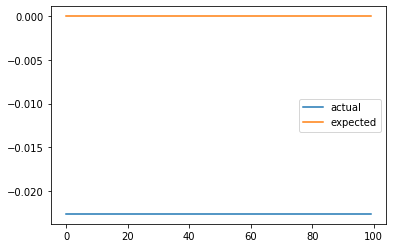

In [128]:
testing_result_df = pd.DataFrame({'actual':actual, 'expected':expected})
testing_result_df.plot()